## Complex PyTorch for Music Genre Classification

In [30]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [31]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

### Data Preparation

In [32]:
DATASET_PATH = "data/genres_original/"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [33]:
genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


### MFCCS

In [34]:
class MusicFeatureExtractor:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        audio_fft = np.square(np.abs(audio_fft))
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(audio_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        return np.array([cepstral_coefficents])

class MusicFeatureExtractorComplex:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(audio_fft))  
        audio_filtered[audio_filtered == 0] = self.epsilon # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        return np.array([cepstral_coefficents])

In [35]:
class GenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.mfcc_extractor = MusicFeatureExtractor(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target


class GenreDatasetPhaseMFCC(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.complex64), target

## 1. No phase data

In [36]:
train_dataset = GenreDatasetMFCC("data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = True)
test_dataset = GenreDatasetMFCC("data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

In [37]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 2, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 2, 1)
        self.fc1 = nn.Linear(30*2*20, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.302511	Accuracy: 9.38%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 1.801547	Accuracy: 25.46%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 1.784472	Accuracy: 30.86%
Epoch 0 - Time: 25255.47s - Train Loss: 1.858769 - Train Accuracy: 32.77%
Test Loss: 1.765009 - Test Accuracy: 36.81%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.812801	Accuracy: 40.62%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 1.517712	Accuracy: 42.17%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 1.448928	Accuracy: 43.94%
Epoch 1 - Time: 28155.00s - Train Loss: 1.555604 - Train Accuracy: 43.73%
Test Loss: 1.485422 - Test Accuracy: 47.69%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 1.688113	Accuracy: 53.12%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 1.349083	Accuracy: 48.61%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.157676	Accuracy: 48.71%
Epoch 2 - Time: 795.21s - Train Loss: 1.407167 - Train Accuracy: 49.21%
Test Loss: 1.414926 - Test Accuracy: 47.75%

In [38]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.431872	Accuracy: 3.12%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 1.738196	Accuracy: 30.63%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 1.561128	Accuracy: 35.53%
Epoch 0 - Time: 1970.13s - Train Loss: 1.742194 - Train Accuracy: 37.58%
Test Loss: 1.555900 - Test Accuracy: 45.75%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.467655	Accuracy: 50.00%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 1.334699	Accuracy: 47.34%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 1.356867	Accuracy: 48.55%
Epoch 1 - Time: 528.77s - Train Loss: 1.434099 - Train Accuracy: 48.69%
Test Loss: 1.654952 - Test Accuracy: 42.12%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 1.496791	Accuracy: 53.12%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 1.346001	Accuracy: 53.65%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.278135	Accuracy: 55.24%
Epoch 2 - Time: 232.54s - Train Loss: 1.275838 - Train Accuracy: 55.60%
Test Loss: 1.635031 - Test Accuracy: 46.31%

T

## 2. Phase Data: Workflow 1

In [39]:
train_dataset = GenreDatasetPhaseMFCC("data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC("data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.457539	Accuracy: 0.00%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 1.896499	Accuracy: 19.86%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 1.868746	Accuracy: 23.45%
Epoch 0 - Time: 226.10s - Train Loss: 2.042841 - Train Accuracy: 25.02%
Test Loss: 1.890326 - Test Accuracy: 29.81%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.821850	Accuracy: 40.62%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 2.078488	Accuracy: 30.94%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 1.896116	Accuracy: 31.62%
Epoch 1 - Time: 224.94s - Train Loss: 1.862578 - Train Accuracy: 32.26%
Test Loss: 1.965093 - Test Accuracy: 30.00%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 1.499644	Accuracy: 53.12%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 2.242279	Accuracy: 35.89%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.671886	Accuracy: 34.59%
Epoch 2 - Time: 223.47s - Train Loss: 1.811675 - Train Accuracy: 34.39%
Test Loss: 1.881417 - Test Accuracy: 29.81%

Tr

## 3. Phase Data: Workflow 2

In [40]:
class MusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents*np.exp(1j*phase_coefficents)])

class GenreDatasetPhaseMFCC2(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.complex64), target

In [41]:
train_dataset = GenreDatasetPhaseMFCC2("data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC2("data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.324414	Accuracy: 15.62%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 1.984264	Accuracy: 15.19%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.203317	Accuracy: 18.72%
Epoch 0 - Time: 799.61s - Train Loss: 2.118728 - Train Accuracy: 20.85%
Test Loss: 2.064254 - Test Accuracy: 21.75%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 1.988714	Accuracy: 28.12%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 1.883760	Accuracy: 26.89%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.048279	Accuracy: 29.90%
Epoch 1 - Time: 217.91s - Train Loss: 1.878141 - Train Accuracy: 30.39%
Test Loss: 2.005993 - Test Accuracy: 25.75%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.119460	Accuracy: 28.12%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 1.545110	Accuracy: 32.83%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.650869	Accuracy: 34.11%
Epoch 2 - Time: 220.60s - Train Loss: 1.805436 - Train Accuracy: 33.73%
Test Loss: 1.961472 - Test Accuracy: 28.62%

T

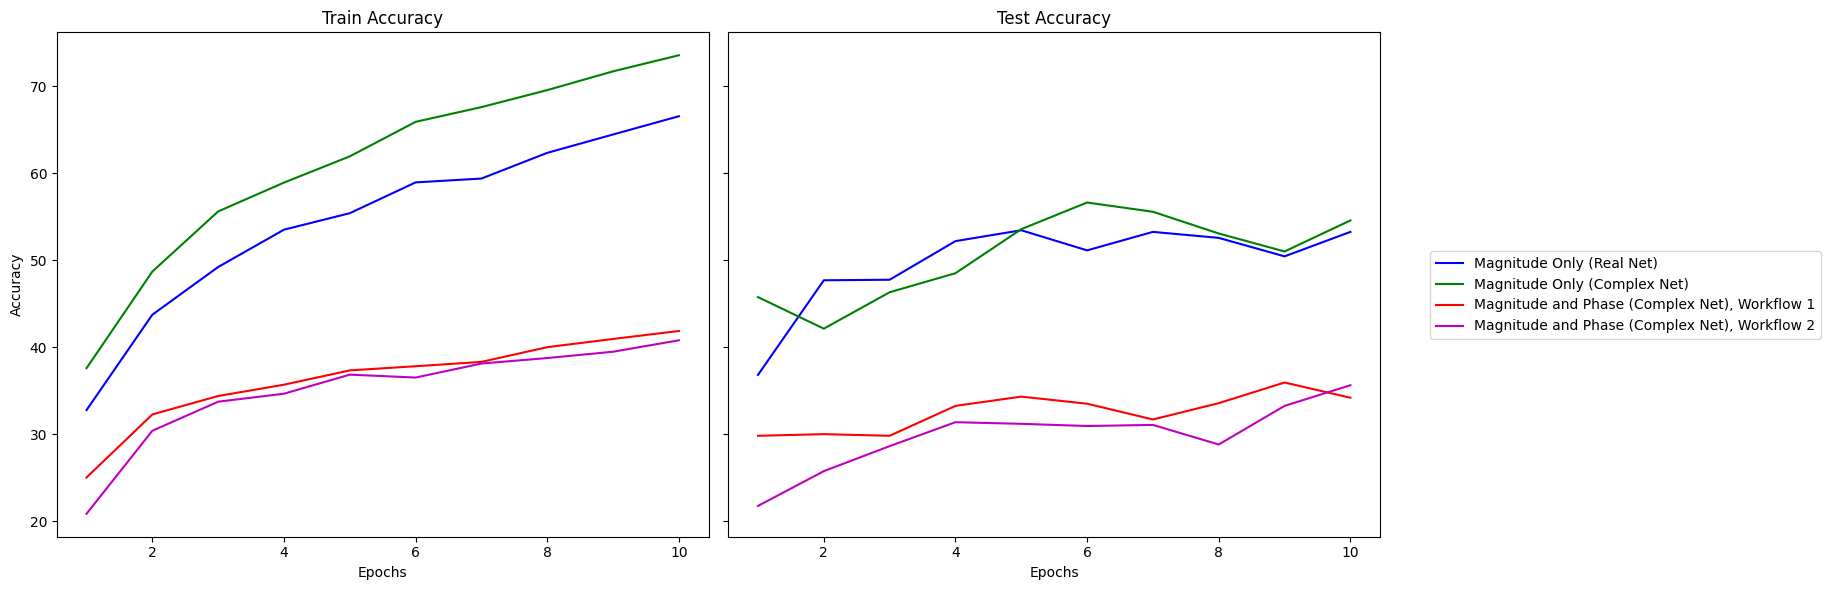

In [43]:
# Data for the four scenarios
data = {
    "Magnitude Only (Real Net)": metrics_dict_e1,
    "Magnitude Only (Complex Net)": metrics_dict_e2,
    "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4
}
# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()


# Experiment 3: GNN

In [50]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

DATASET_PATH = "data/train"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 64
NUM_EPOCHS = 10

genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


In [51]:
class GNNMusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents]), np.array([phase_coefficents])
    
class GNNGenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target

class GNNGenreDatasetPhaseMFCC2(GNNGenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = GNNMusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[2]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc, cur_phase = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc, cur_phase = self.adjust_shape(cur_mfcc), self.adjust_shape(cur_phase)
        return torch.tensor(cur_mfcc, dtype=torch.float32), torch.tensor(cur_phase, dtype=torch.float32), target

In [55]:
train_dataset = GNNGenreDatasetPhaseMFCC2("data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GNNGenreDatasetPhaseMFCC2("data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

## 1. Simple Graph Net (Only magnitude)

In [56]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [57]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.350854	Accuracy: 18.75%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.213250	Accuracy: 17.17%
Epoch 0 - Time: 267.98s - Train Loss: 2.235301 - Train Accuracy: 17.35%
Test Loss: 2.190827 - Test Accuracy: 18.25%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 2.189609	Accuracy: 20.31%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.169057	Accuracy: 20.11%
Epoch 1 - Time: 252.13s - Train Loss: 2.149410 - Train Accuracy: 20.32%
Test Loss: 2.214232 - Test Accuracy: 18.56%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.090006	Accuracy: 17.19%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 2.108877	Accuracy: 21.61%
Epoch 2 - Time: 283.50s - Train Loss: 2.127587 - Train Accuracy: 21.68%
Test Loss: 2.143094 - Test Accuracy: 21.25%

Train Epoch:   3 [     0/  8390 (  0%)]	Loss: 2.108999	Accuracy: 18.75%
Train Epoch:   3 [  6400/  8390 ( 76%)]	Loss: 2.152835	Accuracy: 21.19%
Epoch 3 - Time: 217.27s - Train Loss: 2.132780 - Train Accuracy: 21.55%
T

## 2. Simple Graph Net (Magniude + phase wieghts)

In [58]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model([data, data2])
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model([data, data2])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [59]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        x, phase_data = x[0], x[1]
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        phase_data = torch.mean(phase_data.view(-1, num_nodes, node_size), axis = 0)
        edge_weight = torch.tensor([torch.mean(np.abs(phase_data[edge_index[0][i].item()] - 
                                                      phase_data[edge_index[1][i].item()])).item() 
                                    for i in range(len(edge_index[0]))])
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index, edge_weight)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e6 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e6)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e6.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.418199	Accuracy: 9.38%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.476737	Accuracy: 18.18%
Epoch 0 - Time: 232.88s - Train Loss: 2.170456 - Train Accuracy: 19.37%
Test Loss: 2.129520 - Test Accuracy: 22.62%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 2.063637	Accuracy: 21.88%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.182909	Accuracy: 23.51%
Epoch 1 - Time: 209.47s - Train Loss: 2.059517 - Train Accuracy: 23.43%
Test Loss: 2.121200 - Test Accuracy: 23.25%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.097477	Accuracy: 28.12%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.817138	Accuracy: 25.42%
Epoch 2 - Time: 206.61s - Train Loss: 2.009798 - Train Accuracy: 25.90%
Test Loss: 2.013123 - Test Accuracy: 27.75%

Train Epoch:   3 [     0/  8390 (  0%)]	Loss: 2.039686	Accuracy: 26.56%
Train Epoch:   3 [  6400/  8390 ( 76%)]	Loss: 1.981197	Accuracy: 27.99%
Epoch 3 - Time: 215.92s - Train Loss: 1.965201 - Train Accuracy: 27.78%
Te

## Plots

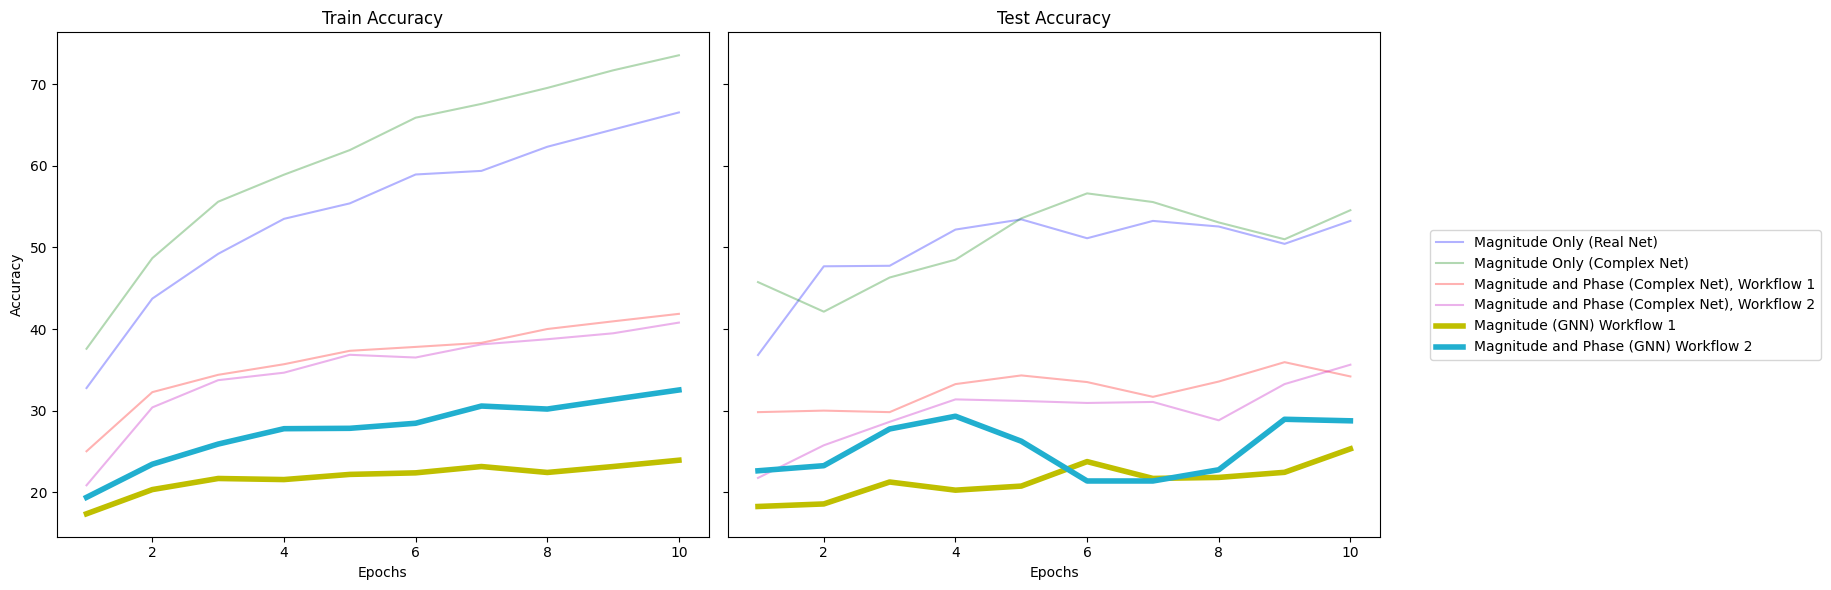

In [60]:
# Data for the four scenarios
data = {
    "Magnitude Only (Real Net)": metrics_dict_e1,
    "Magnitude Only (Complex Net)": metrics_dict_e2,
    "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4,
    "Magnitude (GNN) Workflow 1": metrics_dict_e5,
    "Magnitude and Phase (GNN) Workflow 2": metrics_dict_e6,
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y', "#21AFCF"]
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()

## More Epochs

In [61]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

DATASET_PATH = "data/train"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 32
NUM_EPOCHS = 50

genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

train_dataset = GNNGenreDatasetPhaseMFCC2("data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GNNGenreDatasetPhaseMFCC2("data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


In [63]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

    
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e7 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e7)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e7.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.313675	Accuracy: 15.62%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.141574	Accuracy: 13.92%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 2.282646	Accuracy: 15.69%
Epoch 0 - Time: 250.86s - Train Loss: 2.252156 - Train Accuracy: 16.58%
Test Loss: 2.206960 - Test Accuracy: 18.06%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 2.133665	Accuracy: 18.75%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 2.200405	Accuracy: 20.20%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 2.198791	Accuracy: 19.59%
Epoch 1 - Time: 254.77s - Train Loss: 2.177050 - Train Accuracy: 19.59%
Test Loss: 2.152351 - Test Accuracy: 21.06%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.145184	Accuracy: 21.88%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 2.129136	Accuracy: 18.75%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 2.206037	Accuracy: 19.98%
Epoch 2 - Time: 277.86s - Train Loss: 2.175109 - Train Accuracy: 19.83%
Test Loss: 2.190747 - Test Accuracy: 21.06%

T

In [64]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model([data, data2])
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model([data, data2])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))
    

class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 10)

    def forward(self, x):  # Pass edge_index for GNN
        x, phase_data = x[0], x[1]
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        phase_data = torch.mean(phase_data.view(-1, num_nodes, node_size), axis = 0)
        edge_weight = torch.tensor([torch.mean(np.abs(phase_data[edge_index[0][i].item()] - 
                                                      phase_data[edge_index[1][i].item()])).item() 
                                    for i in range(len(edge_index[0]))])
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index, edge_weight)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e8 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e8)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e8.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  8390 (  0%)]	Loss: 2.411947	Accuracy: 9.38%
Train Epoch:   0 [  3200/  8390 ( 38%)]	Loss: 2.088868	Accuracy: 16.92%
Train Epoch:   0 [  6400/  8390 ( 76%)]	Loss: 1.936989	Accuracy: 19.65%
Epoch 0 - Time: 214.89s - Train Loss: 2.148292 - Train Accuracy: 20.33%
Test Loss: 2.056596 - Test Accuracy: 24.44%

Train Epoch:   1 [     0/  8390 (  0%)]	Loss: 2.057529	Accuracy: 28.12%
Train Epoch:   1 [  3200/  8390 ( 38%)]	Loss: 1.961258	Accuracy: 22.59%
Train Epoch:   1 [  6400/  8390 ( 76%)]	Loss: 1.714180	Accuracy: 24.60%
Epoch 1 - Time: 215.62s - Train Loss: 2.022794 - Train Accuracy: 24.95%
Test Loss: 2.036373 - Test Accuracy: 26.81%

Train Epoch:   2 [     0/  8390 (  0%)]	Loss: 2.094121	Accuracy: 25.00%
Train Epoch:   2 [  3200/  8390 ( 38%)]	Loss: 1.835997	Accuracy: 26.98%
Train Epoch:   2 [  6400/  8390 ( 76%)]	Loss: 1.712380	Accuracy: 27.11%
Epoch 2 - Time: 217.76s - Train Loss: 1.980376 - Train Accuracy: 27.18%
Test Loss: 2.155264 - Test Accuracy: 23.31%

Tr

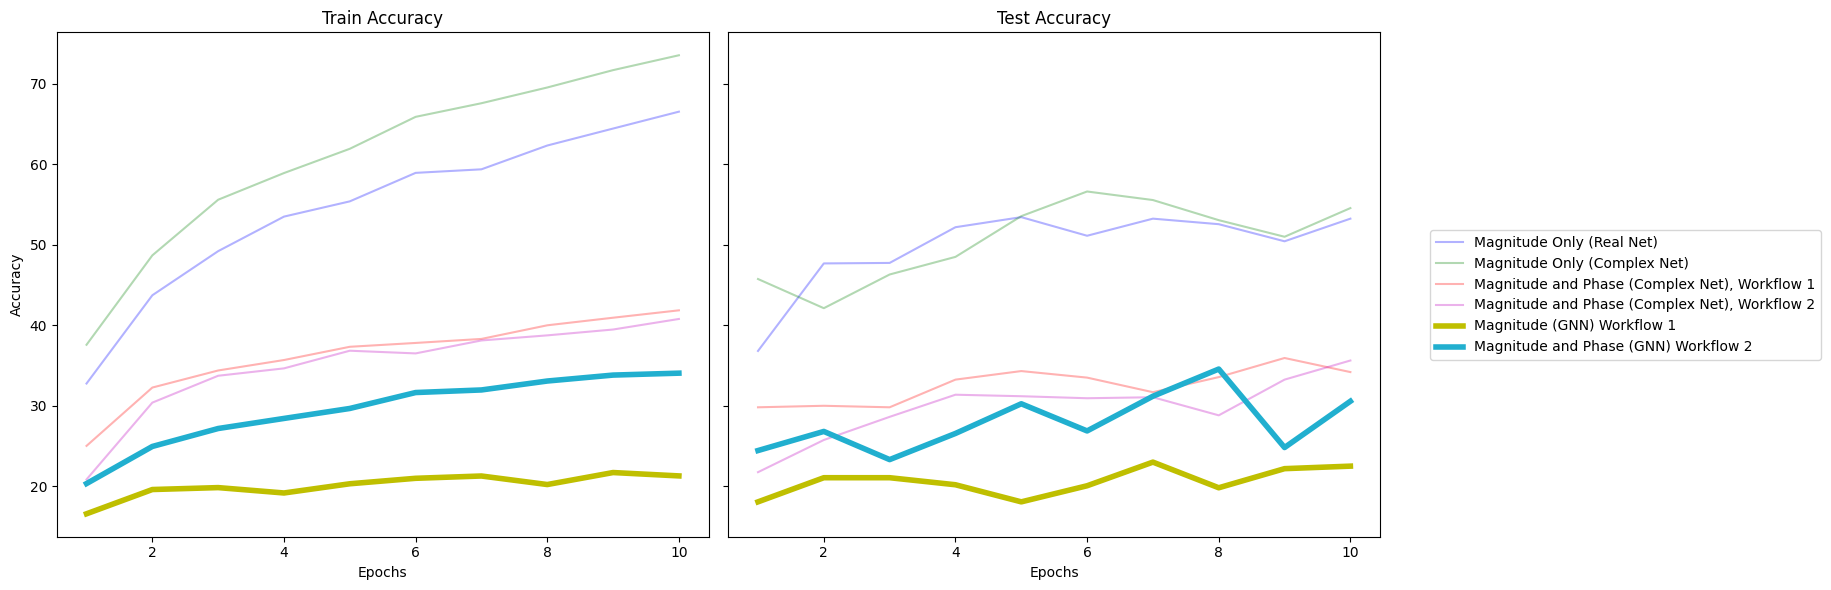

In [71]:
# Data for the four scenarios
data = {
    "Magnitude Only (Real Net)": metrics_dict_e1,
    "Magnitude Only (Complex Net)": metrics_dict_e2,
    "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4,
    "Magnitude (GNN) Workflow 1": {k:v[0:10] for k,v in metrics_dict_e7.items()},
    "Magnitude and Phase (GNN) Workflow 2": {k:v[0:10] for k,v in metrics_dict_e8.items()},
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y', "#21AFCF"]
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()

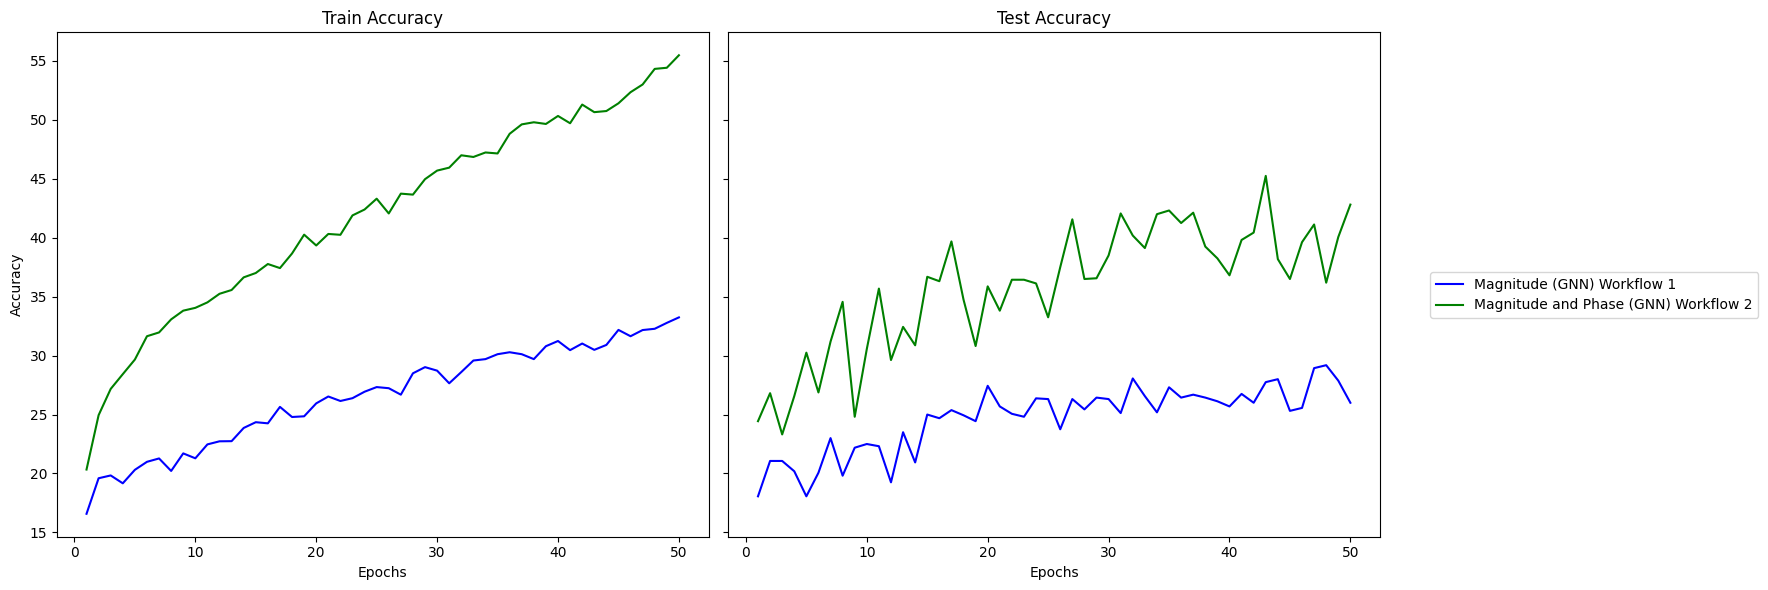

In [68]:
# Data for the four scenarios
data = {
    # "Magnitude Only (Real Net)": metrics_dict_e1,
    # "Magnitude Only (Complex Net)": metrics_dict_e2,
    # "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    # "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4,
    "Magnitude (GNN) Workflow 1": metrics_dict_e7,
    "Magnitude and Phase (GNN) Workflow 2": metrics_dict_e8,
}

# Data for plotting
epochs = range(1, 51)
colors = ['b', 'g', 'r', 'm', 'y', "#21AFCF"]
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()